# Model Evaluation / Comparison

In [1]:
# my virtual environments are rarely properly connected to jupyter so this fixes that. 
# you prolly won't need this cell but running it won't hurt anything either
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [2]:
import torch
from model_comparison import  plot_column_from_csv, evaluate_models

In [3]:
models_to_compare = [
    'templateGPT_1m_5ft11_and_skinnyfat',
    'templateGPT_1m_short_and_thicc',
    'templateGPT_1m_tall_and_skinny',
    'templateGPT_2m_CosineNorm',
    'templateGPT_2m_LayerNorm',
    'templateGPT_2m_RMSNorm',
    'templateGPT_3m_GatedMLP',
    'templateGPT_3m_NotGatedMLP',
    'templateGPT_4m_GeGLU',
    'templateGPT_4m_SwiGLU'
]

### first up we'll look at loss curves
notice that even with a log scale I had to splice out the first 5% to make the lines distinct

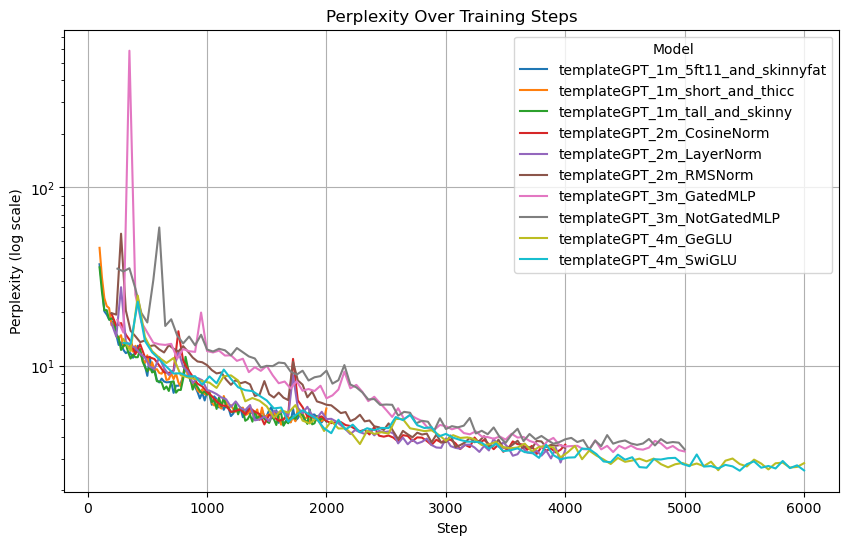

In [4]:
plot_column_from_csv(models_to_compare, 'Step', 'Perplexity', log_y=True, trim_percentage=5)

### now let's compare individual token accuracies
we'll compare topk teacher-forcing accuracies since these models really aren't good enough to be looking at actual inference output

In [9]:
results = evaluate_models(models_to_compare, topk = 3, batch_size = 100)

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-40971520ba3bacdf/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


931.136K parameters
ModelConfig(dim=64, device='cpu', tokenizer='bpe_v1_tinyStories', vocab_len=8192, num_layers=8, second_resid_norm=False, mlp_hidden_mult=4, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=4, num_kv_heads=1, head_dim=28, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06)
Model(
  (token_embedder): Embedding(8195, 64)
  (layers): ModuleList(
    (0-7): 8 x Layer(
      (pre_attn_norm): Norm()
      (attn): MQA(
        (Wq): Linear(in_features=64, out_features=112, bias=False)
        (Wk): Linear(in_features=64, out_features=28, bias=False)
        (Wv): Linear(in_features=64, out_features=28, bias=False)
        (Wo): Linear(in_features=112, out_features=64, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wup): Linear(in_features=64, out_features=170, bias=False)
        (Wgate): Linear(in_features=64, out_features=170, bias=False)
        (Wdown): L

In [10]:
# Display the results for each model
import pandas as pd

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(results.items()), columns=['Model', 'Top-k Accuracy'])

# Convert decimal percentages to formatted strings
df['Top-k Accuracy'] = df['Top-k Accuracy'].apply(lambda x: f"{x:.2%}")

# Display the DataFrame
print(df.to_string(index=False))


                             Model Top-k Accuracy
templateGPT_1m_5ft11_and_skinnyfat         68.31%
    templateGPT_1m_short_and_thicc         67.81%
    templateGPT_1m_tall_and_skinny         68.36%
         templateGPT_2m_CosineNorm         72.24%
          templateGPT_2m_LayerNorm         72.85%
            templateGPT_2m_RMSNorm         72.13%
           templateGPT_3m_GatedMLP         72.68%
        templateGPT_3m_NotGatedMLP         71.70%
              templateGPT_4m_GeGLU         74.75%
             templateGPT_4m_SwiGLU         75.10%


# in the future it'd be cool to build out an automated GPT-4 rater like what they used in the TinyStories paper

# also once the hyperparameter search module is working i should build a system that performs a regression on the hyperparameters tested to predict teacher-forcing topk accuracy. likely need to include both linear, quadratic, & interaction terms in the regression and then do a lasso to remove useless terms